In [11]:
import sys
import pandas as pd
import seaborn as sns
sns.set();
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
# from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
# from isolation_forest import *
from sisään_uloskäynnit import *

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 2549
uniques in y 2778
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  10000
Ouliers removed:     152
Data after:  9848


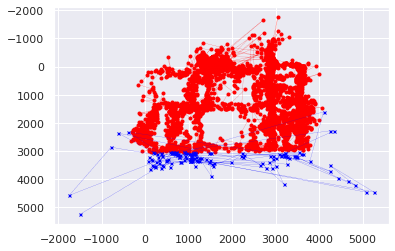

In [12]:
df = database_query("SELECT * FROM SensorData limit 10000")
df = find_outliers(df)
df = clean_dataframe(df)

In [13]:
# def xy_to_grid(df,x,y,grid_size):
    
#     x_cut = pd.cut(df.x, grid_size,labels=False)
#     y_cut = pd.cut(df.y, grid_size,labels=False)

#     # Laitetaan saadut liukuluvut dataframeen
#     df['x_grid'] = x_cut.values
#     df['y_grid'] = y_cut.values
    
#     # Laitetaan x ja y str ja sitte + yhteen 
#     xy_grid_temp = df['x_grid'].astype(str) + '.' + df['y_grid'].astype(str)

#     df['grid_id'] = df['y_grid'] *  grid_size + df['x_grid']
#     df = df.reset_index(drop=True)
    
#     return df

# Määritellään gridin koko ja muokataan gridiksi
grid_size = 50
df = xy_to_grid(df,df["x"], df["y"], grid_size)
df

,index,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,0,1,2020-06-24 15:20:08.533,2762,-257,35,15,785
1,1,1,2020-06-24 15:20:08.620,2870,-344,36,14,736
2,2,1,2020-06-24 15:20:09.623,2916,-344,36,14,736
3,3,1,2020-06-24 15:20:09.623,2894,-254,36,15,786
4,4,1,2020-06-24 15:20:10.116,2888,-188,36,16,836
...,...,...,...,...,...,...,...,...
9623,9995,1,2020-06-29 13:19:16.418,1301,-120,18,17,868
9624,9996,1,2020-06-29 13:19:25.418,1301,-119,18,17,868
9625,9997,1,2020-06-29 13:19:35.418,1305,-112,18,17,868
9626,9998,1,2020-06-29 13:19:45.418,1305,-112,18,17,868


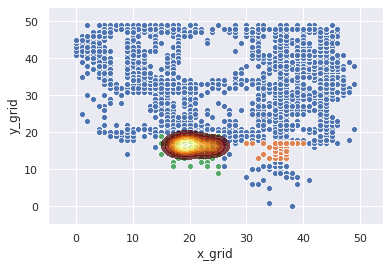

In [14]:
def xy_to_ID(x,y, grid_size):
    ID = grid_size*y+x
    return ID
# Haetaan sisäänkäynnin ja kassojen sijainnit grid-arvoina
in_x, in_y = sisään(df, grid_size)
out_x, out_y = ulos(df, grid_size)

# Muokataan sijainnit id:iksi
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df.x_grid, df.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()

In [15]:
# Haetaan uniikit id:t
in_ID = in_ID.unique()
out_ID = out_ID.unique()

In [21]:
cleaned_xy = df.copy()
class karry:
    def __init__(self, ajokerta):
        self.ajokerta = []
        self.node_id = []
        self.timestamp = []
        self.x = []
        self.y = []
        self.ID = []
      
        
    def lisaa(self,ajokerta, node_id, timestamp, ID, x, y):
        self.ajokerta.append(ajokerta)
        self.node_id.append(node_id)
        self.timestamp.append(timestamp)
        self.ID.append(ID)
        self.x.append(x)
        self.y.append(y)
        

karrylista = []      #tähän tallennetaan kärryt
ajokerta = 0   # pidetään kirjaa kuinka monta kertaa kärry on ajanut kaupan läpi. Käytetään Kärryjen etsimiseen ja erotteluun
Karry = karry(ajokerta)      #luodaan karry
karrylista.append(Karry)     #lisätään ensimmäinen karry listaan, koska data alkaa yleensä kesken ajokerran 

matkalla = False

# Tästä on luotava nopeampi versio..

# käydään jokainen dataframen rivi läpi
for val in range(len(cleaned_xy["grid_id"])-1):
    # Mitataan kahden rivin timestamppien erotusta
    erotus = str(cleaned_xy.timestamp[val+1] - cleaned_xy.timestamp[val])
    
    # Luodaan uusi karry-olio, kun kärry/kori saapuu ensimmäisen kerran sisäänkäynnin kohdalle.
                                                                        # Tarkistetaan, että kaksi pistettä peräkkäin on sisäänkäyntialueella 
                                                                        # (yritetään poissulkea signaalivirheestä alueelle tulleet pisteet)
    if cleaned_xy["grid_id"][val] in in_ID and matkalla == False and  cleaned_xy["grid_id"][val+1] in in_ID:
        matkalla = True
        ajokerta += 1
        Karry = karry(ajokerta)      
        karrylista.append(Karry)
        
    # lopetetaan matka, kun kärry saapuu kassoille (tarkistetaan taas, että useampi piste on alueella peräkkäin)
    elif cleaned_xy["grid_id"][val] in out_ID and cleaned_xy["grid_id"][val+1] in out_ID:
        matkalla = False
        
    # Lisätään rivin tidot objektiin, jos kärry on matkalla ja rivien väliset aikaerot ovat järkevät.
    elif  matkalla == True and cleaned_xy.node_id[val+1] == cleaned_xy.node_id[val]:
        karrylista[ajokerta].lisaa(ajokerta,cleaned_xy.node_id[val], cleaned_xy.timestamp[val],cleaned_xy["grid_id"][val], cleaned_xy.x_grid[val], cleaned_xy.y_grid[val]) 

In [22]:
import pandas as pd
# Putsataan ajokerrat, joissa alle 50 riviä dataa 
clean_list = []
for i in range(len(karrylista)):
    if len(karrylista[i].node_id) > 50:
        clean_list.append(karrylista[i])
karrylista = clean_list

# Käytetään takaisin dataframeen muuttamiseen
class DictKarry:
    def __init__(self, ajot,timet ,nodet, ID, x, y):
        self.tiedot = {"ajokerta": ajot,
                       "timestamp": timet,
                       "node_id": nodet,
                       "ID": ID,
                       "x":x,
                       "y":y}
        
ajokerrat = pd.DataFrame(None,None,None,None,None)
karryt = pd.DataFrame(None,None,None,None,None)

# Käydään ajokerta läpi ja luodaan siihen tallentuneesta datasta dataframe.
for i in range(len(karrylista)):
    karry = DictKarry(karrylista[i].ajokerta,karrylista[i].timestamp,karrylista[i].node_id,karrylista[i].ID, karrylista[i].x, karrylista[i].y)
    karryt = pd.DataFrame(karry.tiedot)
    # Lisätään kaikki ajokerrat vuorollaan dataframeen.
    ajokerrat = ajokerrat.append(karryt,  ignore_index=True)

In [23]:
ajokerrat

,ajokerta,timestamp,node_id,ID,x,y
0,1,2020-06-24 15:20:08.620,1,736,36,14
1,1,2020-06-24 15:20:09.623,1,736,36,14
2,1,2020-06-24 15:20:09.623,1,786,36,15
3,1,2020-06-24 15:20:10.116,1,836,36,16
4,1,2020-06-24 15:20:11.086,1,836,36,16
...,...,...,...,...,...,...
3812,14,2020-06-29 12:27:12.418,1,1220,20,24
3813,14,2020-06-29 12:27:17.418,1,1120,20,22
3814,14,2020-06-29 12:27:18.418,1,1070,20,21
3815,14,2020-06-29 12:27:20.418,1,1020,20,20


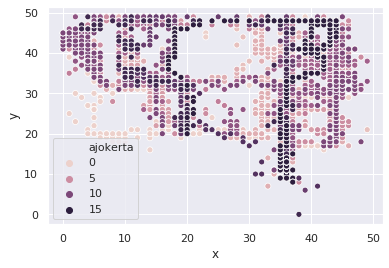

In [24]:
# Kaikki ajokerrat yhdessä
import numpy as np
facet = sns.scatterplot(x="x", y="y", data=ajokerrat, hue="ajokerta")
facet.set_xticks(np.arange(0, grid_size+1,10))
facet.set_yticks(np.arange(0, grid_size+1,10))
plt.show()

444


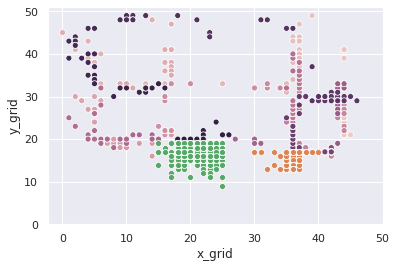

71


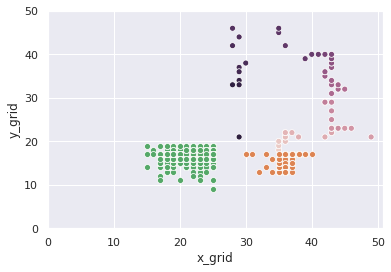

572


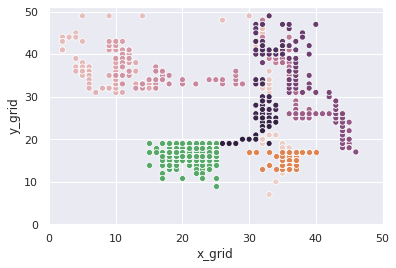

274


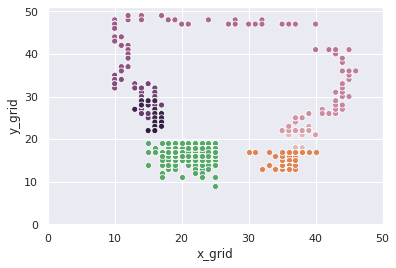

348


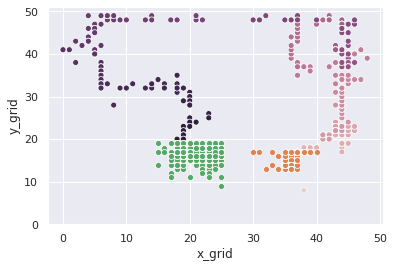

191


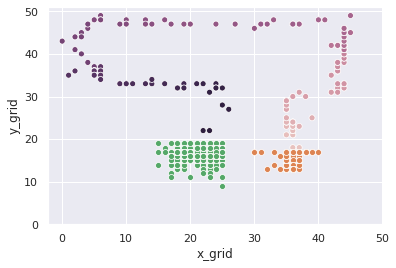

425


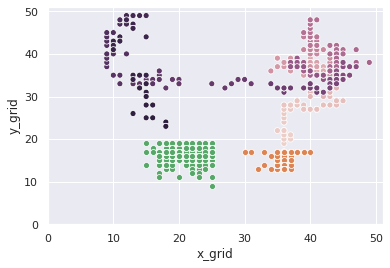

268


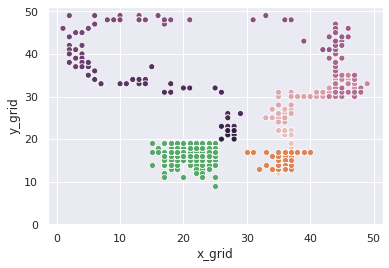

387


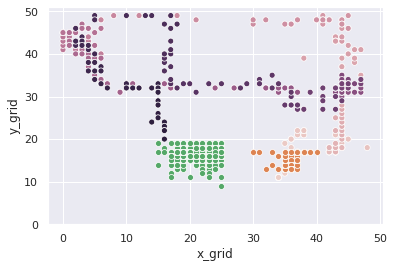

145


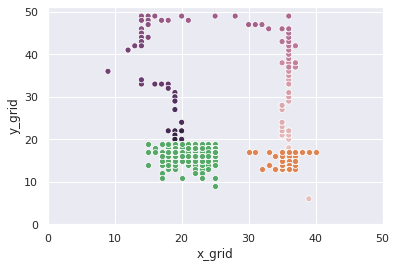

70


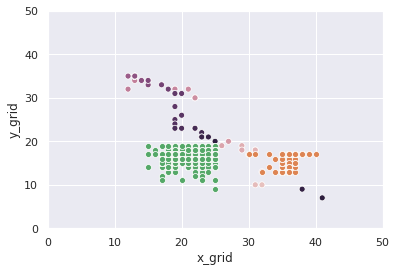

197


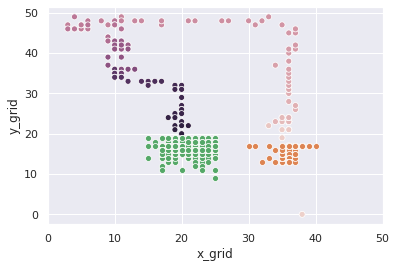

425


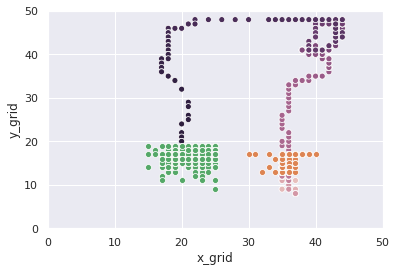

In [25]:
# Plottaa jokaisen ajokerran erikseen.
ajot = ajokerrat["ajokerta"].unique()
ajokerrat["color"] = np.arange(0,len(ajokerrat),1)
for ajo in ajot:
    print(len(ajokerrat[ajokerrat["ajokerta"] == ajo]))
    
    facet = sns.scatterplot(x="x", y="y", data=ajokerrat[ajokerrat["ajokerta"] == ajo],  hue="color")
    sns.scatterplot(x=in_x, y=in_y)
    sns.scatterplot(x=out_x, y=out_y)
    facet.set_xticks(np.arange(0, grid_size+1,10))
    facet.set_yticks(np.arange(0, grid_size+1,10))
    plt.legend([],[], frameon=False)
    plt.show()
    
# Ensimmäisissä on aika paljon häiriötä